# Texas Death Row Data

Some related links


1. [Texas JOD Death Row Site](https://www.tdcj.texas.gov/death_row/)
2. [Brian Klaas on Last Words of Death Row Inmates](https://www.forkingpaths.co/p/the-last-statements-of-death-row)
 
From Klaas's essay:

> Since 1976—when the Supreme Court issued a ruling that allowed the revival of capital punishment in the United States—there have been 581 executions carried out in the Huntsville Unit. That’s about 4 in 10 of all executions in the United States, in a single cramped chamber, in a small town in Texas.

Since this blog was posted the numbr of executions has risen to 583 at the time of the
creation of this notebook.

In [56]:
#https://www.tdcj.texas.gov/death_row/dr_executed_offenders.html
site = "https://www.tdcj.texas.gov/death_row/"
base_url = site + "dr_executed_offenders.html"

In [207]:
import os
import sys
from bs4 import BeautifulSoup
import urllib.request


def parseHtml(html):
    return BeautifulSoup(html, "lxml").contents

class DummyAnchor ():

    def __init__ (self,href,title,text):
    
       self.__dict__ =  dict(href=href,
                             title=title)
       self.text = text
       
    def __getitem__ (self,key):
        return self.__dict__[key]
    
    def __repr__ (self):
        return f'<a href={self["href"]} title={self["title"]}>{self.text}</a>'
    
def make_dummy_last_statement_anchor (name):
    L = name.split()
    lastfirst = ("".join(L[1:] + [L[0]])).lower()
    href=f"dr_info/{lastfirst}last.html"
    title=f"Last Statement of {name}"
    text = "Last Statement"
    return DummyAnchor(href,title,text)

def make_dummy_info_anchor (name):
    L = name.split()
    lastfirst = ("".join(L[1:] + [L[0]])).lower()
    href=f"dr_info/{lastfirst}.html"
    title=f"Inmate Information for {name}"
    text = "Inmate Information"
    return DummyAnchor(href,title,text)




### Extract the data table from the executed offenders page

In [183]:
#print(urllib.request.urlopen.__doc__)
import ssl
import urllib.request

ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

with urllib.request.urlopen(base_url, context=ctx) as f:
    inmate_list_page = f.read()


In [327]:
soup_bowl = parseHtml(inmate_list_page)

584 rows, including the headed row (= 583 executions).

In [333]:
table = soup_bowl[1]('table')[0]
rows = table('tr')
len(rows)

584

10 columns, which include the 2 link columns we are handling later in this NB.

In [350]:
len(rows[0]('th'))

10

### Convert the HTML data table into a `pandas` `DataFrame`.

In [544]:
import pandas as pd

table_TX = pd.read_html(inmate_list_page)[0]
table_TX = table_TX.iloc[:,[0,3,4,5,6,7,8,9]]
table_TX.set_index("Execution",inplace=True)
table_TX["Date"] = [pd.to_datetime(val) for val in table_TX["Date"].values]

# The parser used for astype casting doesnt work.  The mystery is why the version above does.
#converted_dates = table_TX['Date'].values.astype('datetime64[D]')

Some facts about the data:

In [545]:
table_TX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583 entries, 583 to 1
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Last Name    583 non-null    object        
 1   First Name   583 non-null    object        
 2   TDCJ Number  583 non-null    int64         
 3   Age          583 non-null    int64         
 4   Date         583 non-null    datetime64[ns]
 5   Race         583 non-null    object        
 6   County       583 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 36.4+ KB


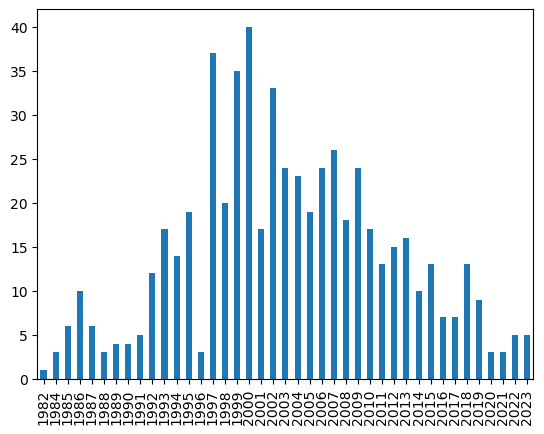

In [541]:
#  Example vectorized of pd.Datetime column
executions_by_year = table_TX["Date"].dt.year.value_counts(sort=False).sort_index()
bar_plot = executions_by_year.plot(kind="bar")

In [542]:
print(f"{table_TX['Age'].mean():.3f}")

40.082


In [543]:
with pd.option_context('display.precision', 3):
    print(table_TX["Race"].value_counts(normalize=True))

White       0.446
Black       0.358
Hispanic    0.190
Other       0.005
Name: Race, dtype: float64


### Add Statement and Info Links to DataFrame (Optional)

Since we process the links and save the contents as files further on in this NB,
there is no real need to add the statement and Info links to this DataFrame.

Nevertheless we describe two options for restoring the link information
to the DataFrame, both of which provide a way for the links to be clickable.

#### Option One

Add two link columns to the DataFrame  wrapping the links in explicit anchor tags.

The DataFrame can then be displayed as an HTML object (shown below) and the links will be clickable.

In [526]:
def make_anchor (sp,site=''):
    """
    Turn a soup object anchor into an html string anchor,
    converting the URL to be non-relative.
    """
    new_url = site + sp['href']
    return f"<a href={new_url} title={sp['title']}>{sp.text}</a>"

def get_col (row_cells,index):
        return [r[index] for r in row_cells]
    
def make_anchors (col,site=''):
    #col = get_col(row_cells,index)
    return [make_anchor(cell('a')[0],site=site) for cell in col]

# rows as extracted from the  Beautiful Soup parse of the 
# Texas JOD Death Row Site (defined above)  omitting header row.
row_cells = [row('td') for row in rows[1:]]

# Get data from 2nd cell in each row
info_col = get_col (row_cells,1)
# Get data from 3rd cell in each row
statement_col = get_col (row_cells,2)

# Convert the Beautiful soup objects to HTML strings
info_links0 = make_anchors(info_col,site=site)
statement_links0 = make_anchors(statement_col,site=site)

# Add the link sequences as cols
table_TX['Info']  = info_links0
table_TX['Statements']  = statement_links0

To Display the links nicely, you need to render the DataFrame as HTML 
and use IPython's `HTML` display function.

They will now be clickable.

In [518]:
from IPython.display import HTML
HTML(table_TX[:10].to_html(render_links=True, escape=False))


,Last Name,First Name,TDCJ Number,Age,Date,Race,County,Info,Statements
Execution,,,,,,,,,
583,"Brown, Jr.",Arthur,999110,52,2023-03-09,Black,Harris,Inmate Information,Last Statement
582,Green,Gary,999561,51,2023-03-07,Black,Dallas,Inmate Information,Last Statement
581,Balentine,John,999315,54,2023-02-09,Black,Potter,Inmate Information,Last Statement
580,Ruiz,Wesley,999536,43,2023-02-01,Hispanic,Dallas,Inmate Information,Last Statement
579,Fratta,Robert,999189,65,2023-01-10,White,Harris,Inmate Information,Last Statement
578,Barbee,Stephen,999507,55,2022-11-16,White,Tarrant,Inmate Information,Last Statement
577,Beatty,Tracy,999484,61,2022-11-09,White,Smith,Inmate Information,Last Statement
576,Ramirez,John,999544,38,2022-10-05,Hispanic,Nueces,Inmate Information,Last Statement
575,Chanthakoummane,Kosol,999529,41,2022-08-17,Other,Collin,Inmate Information,Last Statement


#### Option Two:

Following [Pandas Tutorial Hint](https://github.com/softhints/Pandas-Tutorials/blob/master/styling/create-clickable-link-pandas-dataframe-jupyterlab.ipynb), leave the URLS as (relative-URL) strings and make them clickable
via a style formatting function.

The advantage of this option is information-persistence.  This
makes the links to the website explicit in
the DataFrame as strings, so they can be saved with `df.to_csv()`.
They can still be **displayed** as clickable links, as we'll see.

In [546]:
def make_clickable(url, site, text):
    return f'<a rel="noopener noreferrer" href="{site + url}" target="_blank">{text}</a>'

# Need one-argument functions that apply to data items.  
# OK since the non-url args of `make_clickable` are fixed.
make_clickable_statement = lambda url: make_clickable(url, site=site, text="Inmate Information")
make_clickable_info = lambda url: make_clickable(url, site=site, text="Inmate's Statement")

# Get just the url strings to be used a data items
info_links0 = [f"{td_tag('a')[0]['href']}" for td_tag in info_col]
statement_links0 = [f"{td_tag('a')[0]['href']}" for td_tag in statement_col]

# Add the link sequences as cols
table_TX['Info']  = info_links0
table_TX['Statements']  = statement_links0

The DataFrame in this format:

In [547]:
table_TX[:10]

,Last Name,First Name,TDCJ Number,Age,Date,Race,County,Info,Statements
Execution,,,,,,,,,
583,"Brown, Jr.",Arthur,999110,52,2023-03-09,Black,Harris,dr_info/brownarthur.jpg,dr_info/brownarthurlast.html
582,Green,Gary,999561,51,2023-03-07,Black,Dallas,dr_info/greengary.html,dr_info/greengarylast.html
581,Balentine,John,999315,54,2023-02-09,Black,Potter,dr_info/balentinejohn.html,dr_info/balentinejohnlast.html
580,Ruiz,Wesley,999536,43,2023-02-01,Hispanic,Dallas,dr_info/ruizwesley.html,dr_info/ruizwesleylast.html
579,Fratta,Robert,999189,65,2023-01-10,White,Harris,dr_info/frattarobert.jpg,dr_info/frattarobertlast.html
578,Barbee,Stephen,999507,55,2022-11-16,White,Tarrant,dr_info/barbeestephen.html,dr_info/barbeestephenlast.html
577,Beatty,Tracy,999484,61,2022-11-09,White,Smith,dr_info/beattytracy.html,dr_info/beattytracylast.html
576,Ramirez,John,999544,38,2022-10-05,Hispanic,Nueces,dr_info/ramirezjohn.html,dr_info/ramirezjohnlast.html
575,Chanthakoummane,Kosol,999529,41,2022-08-17,Other,Collin,dr_info/chanthakoummanekosoul.html,dr_info/chanthakoummanekosollast.html


For clickable links, display using a formatting dict providing column-specific hooks for the 
formatting functions defined above:

In [550]:
table_TX.style.format({'Info': make_clickable_info,
                       'Statements': make_clickable_statement})

,Last Name,First Name,TDCJ Number,Age,Date,Race,County,Info,Statements
Execution,,,,,,,,,
583,"Brown, Jr.",Arthur,999110,52,2023-03-09 00:00:00,Black,Harris,Inmate's Statement,Inmate Information
582,Green,Gary,999561,51,2023-03-07 00:00:00,Black,Dallas,Inmate's Statement,Inmate Information
581,Balentine,John,999315,54,2023-02-09 00:00:00,Black,Potter,Inmate's Statement,Inmate Information
580,Ruiz,Wesley,999536,43,2023-02-01 00:00:00,Hispanic,Dallas,Inmate's Statement,Inmate Information
579,Fratta,Robert,999189,65,2023-01-10 00:00:00,White,Harris,Inmate's Statement,Inmate Information
578,Barbee,Stephen,999507,55,2022-11-16 00:00:00,White,Tarrant,Inmate's Statement,Inmate Information
577,Beatty,Tracy,999484,61,2022-11-09 00:00:00,White,Smith,Inmate's Statement,Inmate Information
576,Ramirez,John,999544,38,2022-10-05 00:00:00,Hispanic,Nueces,Inmate's Statement,Inmate Information
575,Chanthakoummane,Kosol,999529,41,2022-08-17 00:00:00,Other,Collin,Inmate's Statement,Inmate Information


### Save DateFrame to CSV

In [414]:
os.getcwd()

'/Users/gawron/Desktop/src/sphinx/python_for_ss_extras/colab_notebooks/python-for-social-science/examples/texas_death_statements'

In [530]:
csv_file = "texas_executions.csv"
table_TX.to_csv(csv_file)

###  Read CSV File in

In [549]:
import numpy as np
import pandas as pd

table_TX = pd.read_csv(csv_file,index_col=0)
table_TX['Date'] = [pd.to_datetime(val) for val in table_TX["Date"].values]

In [539]:
table_TX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583 entries, 583 to 1
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Last Name    583 non-null    object        
 1   First Name   583 non-null    object        
 2   TDCJ Number  583 non-null    int64         
 3   Age          583 non-null    int64         
 4   Date         583 non-null    datetime64[ns]
 5   Race         583 non-null    object        
 6   County       583 non-null    object        
 7   Info         583 non-null    object        
 8   Statements   583 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 45.5+ KB


In [537]:
# Read write equivalence has been verified
#(table_TX == table_TX0).all()

Last Name      True
First Name     True
TDCJ Number    True
Age            True
Date           True
Race           True
County         True
Info           True
Statements     True
dtype: bool

### Extract and clean up the links from the executed offenders page

In [208]:
# This all (inc. defining vars) shd have been done above
# with urllib.request.urlopen(base_url, context=ctx) as f:
#    inmate_list_page = f.read()

# This is the same soup the data table was extracted from.
# The links are from the columns labeled "Links", which were omitted in first creating the DatFrame.
# soup_bowl = parseHtml(inmate_list_page)

inmate_info_links = [t for t in soup_bowl[1]('a') if  t.get("href","").startswith('dr_info')]
#Misparsed inmate  links restored (the files linked to exist, but the links were ignored in the soup)
rc_anchor0= make_dummy_last_statement_anchor ("Ruben Cardenas")
rc_anchor1 = make_dummy_info_anchor ("Robert Pruett")
rc_anchor2 = make_dummy_last_statement_anchor ("Robert Pruett")
for rc_anchor in [rc_anchor2,rc_anchor1,rc_anchor]:
    inmate_info_links.insert(77,rc_anchor)

### Testing the links before scraping

Out To file:

In [222]:
print(len(inmate_info_links))
num_executions = 583
with open("death_row_linklist.txt",'w') as ofh:
    for (i,anchor) in enumerate(inmate_info_links):
       href,title,text = anchor["href"],anchor["title"],anchor.text
       print(num_executions, i, text, title,file=ofh)
       if href=="dr_info/no_last_statement.html":
          # This is a no statement link
           print("------------", href,file=ofh)
       if href=="dr_info/no_info_available.html":
           # This is a no info available link
           print("------------", href,file=ofh)
       if i%2 == 1:
           print(file=ofh)
           num_executions -= 1

1166


Output stdout:

In [224]:
print(len(inmate_info_links))
num_executions = 583

for (i,anchor) in enumerate(inmate_info_links):
   href,title,text = anchor["href"], anchor["title"], anchor.text
   print(num_executions, i, text, title)
   if href=="dr_info/no_last_statement.html":
      # This is a no statement link
       print("------------", href)
   if href=="dr_info/no_info_available.html":
       # This is a no info available link
       print("------------", href)
   if i%2 == 1:
       print()
       num_executions -= 1

1166
583 0 Inmate Information Inmate Information for Arthur Brown, Jr.
583 1 Last Statement Last Statement of Arthur Brown, Jr.

582 2 Inmate Information Inmate Information for Gary Green
582 3 Last Statement Last Statement of Gary Green

581 4 Inmate Information Inmate Information for John Balentine
581 5 Last Statement Last Statement of John Balentine

580 6 Inmate Information Inmate Information for Wesley Ruiz
580 7 Last Statement Last Statement of Wesley Ruiz

579 8 Inmate Information Inmate Information for Robert Fratta
579 9 Last Statement Last Statement of Robert Fratta

578 10 Inmate Information Inmate Information for Stephen Barbee
578 11 Last Statement Last Statement of Stephen Barbee

577 12 Inmate Information Inmate Information for Tracy Beatty
577 13 Last Statement Last Statement of Tracy Beatty

576 14 Inmate Information Inmate Information for John Ramirez
576 15 Last Statement Last Statement of John Ramirez

575 16 Inmate Information Inmate Information for Kosol Chanthak

# Fetching linked-to files (info and statement files)

To do:  The big for-loop should be a function, so as to make its dependnecies on
what comnes earlier in the notebookk explicit.

In [308]:
import time
import re
import ssl
import urllib.request

ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

# There is a case of two death row inmates with the same name,
# so for those inmates only, their info and last statement files are distinguished by appending the
# prisoner number at the end.
rex = re.compile(".*last(\d{0,6})$")

# Initialize if beginning
#html_data_dict = dict()
start = 2

do_statements,do_info = (False,True)

# do_statements => processed_ctr + no_statement_ctr = 583
# do_info => processed_ctr + no_info_ctr = 583
processed_ctr,skipped_ctr = 0,0
no_info_ctr,no_statement_ctr = 0,0
not_done,skipped = [],[]

# How many total inmates have been processed?
# k = start + i
# k%2 == 1: (k+1)/2 
# k%2 == 0: (k/2) + 1
for (i,anchor) in enumerate(inmate_info_links[start:]):
    print(i+start)
    href,title,text = anchor["href"],anchor["title"],anchor.text
    new_url = site + href
    (fn_in, ext) = os.path.splitext(href)
    if href=="dr_info/no_last_statement.html":
        name = title[18:]
        href = f"dr_info/{name}_no_last_statement.html"
        html_data_dict[(href,title,text)] = "No last statement"
        print(f"No statement {i+start} {href} {title} {text}")
        no_statement_ctr +=1
    elif do_info and href=="dr_info/no_info_available.html":
        name = title[23:]
        href = f"dr_info/{name}_no_info_available.html"
        html_data_dict[(href,title,text)] = "No info available"
        print(f"No info {i+start} {href} {title} {text}")
        no_info_ctr +=1
    elif ((do_statements and re.match(rex, fn_in)) or \
          (do_info and not re.match(rex, fn_in))):
        # Actually doing an internet download
        print(f"Processing {i+start} {href} {title} {text}")
        with urllib.request.urlopen(new_url, context=ctx) as f:
            html_data_dict[(href,title,text)] = f.read()
            time.sleep(15)
        processed_ctr +=1
    elif ((do_statements and not re.match(rex,fn_in)) or \
          (do_info and re.match(rex,fn_in))):
        #print(f"Skipping {i+start} {href} {title} {text}")
        skipped_ctr += 1
    else:
        # This shd always be empty.  Debugging trap
        not_done.append((i+start,anchor))
print()

2
Processing 2 dr_info/greengary.html Inmate Information for Gary Green Inmate Information
3
4
Processing 4 dr_info/balentinejohn.html Inmate Information for John Balentine Inmate Information
5
6
Processing 6 dr_info/ruizwesley.html Inmate Information for Wesley Ruiz Inmate Information
7
8
Processing 8 dr_info/frattarobert.jpg Inmate Information for Robert Fratta Inmate Information
9
10
Processing 10 dr_info/barbeestephen.html Inmate Information for Stephen Barbee Inmate Information
11
12
Processing 12 dr_info/beattytracy.html Inmate Information for Tracy Beatty Inmate Information
13
14
Processing 14 dr_info/ramirezjohn.html Inmate Information for John Ramirez Inmate Information
15
16
Processing 16 dr_info/chanthakoummanekosoul.html Inmate Information for Kosol Chanthakoummane Inmate Information
17
18
Processing 18 dr_info/buntionc.jpg Inmate Information for Carl Buntion Inmate Information
19
20
Processing 20 dr_info/rhoadesrick.html Inmate Information for Rick Rhoades Inmate Informati

161
162
Processing 162 dr_info/rossvaughn.html Inmate Information for Vaughn Ross Inmate Information
163
164
Processing 164 dr_info/quintanillajohn.html Inmate Information for John Quintanilla Inmate Information
165
166
Processing 166 dr_info/mccarthykimberly.html Inmate Information for Kimberly McCarthy Inmate Information
167
168
Processing 168 dr_info/chesterelroy.html Inmate Information for Elroy Chester Inmate Information
169
170
Processing 170 dr_info/williamsjeffery.html Inmate Information for Jeffrey Williams Inmate Information
171
172
Processing 172 dr_info/parrcarroll.html Inmate Information for Carroll Parr Inmate Information
173
174
Processing 174 dr_info/cobbrichard.html Inmate Information for Richard Cobb Inmate Information
175
176
Processing 176 dr_info/threadgillronnie.html Inmate Information for Ronnie Threadgill Inmate Information
177
178
Processing 178 dr_info/lewisrickey.html Inmate Information for Rickey Lewis Inmate Information
179
180
Processing 180 dr_info/blueca

309
310
Processing 310 dr_info/ortizricardo.html Inmate Information for Ricardo Ortiz Inmate Information
311
312
Processing 312 dr_info/martinezvirgil.html Inmate Information for Virgil Martinez Inmate Information
313
314
Processing 314 dr_info/perkinsreginald.html Inmate Information for Reginald Perkins Inmate Information
315
316
Processing 316 dr_info/moorefrank.jpg Inmate Information for Frank Moore Inmate Information
317
318
Processing 318 dr_info/moorecurtis.html Inmate Information for Curtis Moore Inmate Information
319
320
Processing 320 dr_info/hudsonrobert.html Inmate Information for Robert Hudson Inmate Information
321
322
Processing 322 dr_info/mannsdenard.html Inmate Information for Denard Manns Inmate Information
323
324
Processing 324 dr_info/whitakergeorge.jpg Inmate Information for George Whitaker, III Inmate Information
325
326
Processing 326 dr_info/taylorelkie.jpg Inmate Information for Elkie Taylor Inmate Information
327
328
Processing 328 dr_info/wrightgregory.html

447
448
Processing 448 dr_info/smithclyde.jpg Inmate Information for Clyde Smith, Jr. Inmate Information
449
450
Processing 450 dr_info/nevillerobert.html Inmate Information for Robert Neville, Jr. Inmate Information
451
452
Processing 452 dr_info/elizaldejaime.jpg Inmate Information for Jaime Elizalde, Jr. Inmate Information
453
454
Processing 454 dr_info/dudleymarion.jpg Inmate Information for Marion Dudley Inmate Information
455
No statement 455 dr_info/Marion Dudley_no_last_statement.html Last Statement of Marion Dudley Last Statement
456
Processing 456 dr_info/thomasshannon.jpg Inmate Information for Shannon Thomas Inmate Information
457
458
Processing 458 dr_info/rowellrobert.html Inmate Information for Robert Rowell Inmate Information
459
460
Processing 460 dr_info/thackercharles.jpg Inmate Information for Charles Thacker Inmate Information
461
462
Processing 462 dr_info/whitemelvin.html Inmate Information for Melvin White Inmate Information
463
464
Processing 464 dr_info/ramire

583
584
Processing 584 dr_info/baltazarjohn.html Inmate Information for John Baltazar Inmate Information
585
No statement 585 dr_info/John Baltazar_no_last_statement.html Last Statement of John Baltazar Last Statement
586
Processing 586 dr_info/gallamoresamuel.jpg Inmate Information for Samuel Gallamore Inmate Information
587
588
Processing 588 dr_info/collierjames.jpg Inmate Information for James Collier Inmate Information
589
590
Processing 590 dr_info/rojasleonard.jpg Inmate Information for Leonard Rojas Inmate Information
591
No statement 591 dr_info/Leonard Rojas_no_last_statement.html Last Statement of Leonard Rojas Last Statement
592
Processing 592 dr_info/chappellwilliam.jpg Inmate Information for William Chappell Inmate Information
593
594
Processing 594 dr_info/ogancraig.jpg Inmate Information for Craig Ogan Inmate Information
595
596
Processing 596 dr_info/powelljames.jpg Inmate Information for James Powell Inmate Information
597
598
Processing 598 dr_info/kingcalvin.jpg Inm

723
724
Processing 724 dr_info/nunciopaul.jpg Inmate Information for Paul Nuncio Inmate Information
725
726
Processing 726 dr_info/burksjohn.jpg Inmate Information for John Burks Inmate Information
727
728
Processing 728 dr_info/masonthomas.jpg Inmate Information for Thomas Mason Inmate Information
729
730
Processing 730 dr_info/carterrobertearl.jpg Inmate Information for Robert Carter Inmate Information
731
732
Processing 732 dr_info/claytonjames.jpg Inmate Information for James Clayton Inmate Information
733
734
Processing 734 dr_info/fosterrichard.jpg Inmate Information for Richard Foster Inmate Information
735
736
Processing 736 dr_info/richardsonjames.jpg Inmate Information for James Richardson Inmate Information
737
738
Processing 738 dr_info/mcbridemichael.jpg Inmate Information for Michael McBride Inmate Information
739
740
Processing 740 dr_info/kitchenswilliam.jpg Inmate Information for William Kitchens Inmate Information
741
742
Processing 742 dr_info/jacksontommy.jpg Inmate

841
842
Processing 842 dr_info/corwindaniel.jpg Inmate Information for Daniel Corwin Inmate Information
843
844
Processing 844 dr_info/mcduffkenneth.jpg Inmate Information for Kenneth McDuff Inmate Information
845
846
Processing 846 dr_info/noblesjohnathan.jpg Inmate Information for Jonathan Nobles Inmate Information
847
848
Processing 848 dr_info/cruzjavier.jpg Inmate Information for Javier Cruz Inmate Information
849
850
Processing 850 dr_info/castillodavid.jpg Inmate Information for David Castillo Inmate Information
851
852
Processing 852 dr_info/teaguedelbert.jpg Inmate Information for Delbert Teague, Jr. Inmate Information
853
854
Processing 854 dr_info/camachogenero.jpg Inmate Information for Genaro Camacho, Jr. Inmate Information
855
856
Processing 856 dr_info/narvaizleopoldo.jpg Inmate Information for Leopoldo Narvaiz Inmate Information
857
No statement 857 dr_info/Leopoldo Narvaiz_no_last_statement.html Last Statement of Leopoldo Narvaiz Last Statement
858
Processing 858 dr_in

971
972
Processing 972 dr_info/hammondkarl.jpg Inmate Information for Karl Hammond Inmate Information
973
No statement 973 dr_info/Karl Hammond_no_last_statement.html Last Statement of Karl Hammond Last Statement
974
Processing 974 dr_info/fearancejohn.jpg Inmate Information for John Fearance Inmate Information
975
976
Processing 976 dr_info/allridgeronald.jpg Inmate Information for Ronald Allridge Inmate Information
977
No statement 977 dr_info/Ronald Allridge_no_last_statement.html Last Statement of Ronald Allridge Last Statement
978
Processing 978 dr_info/mannfletcher.jpg Inmate Information for Fletcher Mann Inmate Information
979
980
Processing 980 dr_info/maysnoble.jpg Inmate Information for Noble Mays Inmate Information
981
No statement 981 dr_info/Noble Mays_no_last_statement.html Last Statement of Noble Mays Last Statement
982
Processing 982 dr_info/hawkinssamuel.jpg Inmate Information for Samuel Hawkins Inmate Information
983
No statement 983 dr_info/Samuel Hawkins_no_last_sta

1077
1078
Processing 1078 dr_info/garrettjohnny.jpg Inmate Information for Johnny Garrett Inmate Information
1079
No statement 1079 dr_info/Johnny Garrett_no_last_statement.html Last Statement of Johnny Garrett Last Statement
1080
No info 1080 dr_info/Joe Cordova_no_info_available.html Inmate Information for Joe Cordova Inmate Information
1081
No statement 1081 dr_info/Joe Cordova_no_last_statement.html Last Statement of Joe Cordova Last Statement
1082
Processing 1082 dr_info/greengw.jpg Inmate Information for G.W. Green Inmate Information
1083
1084
Processing 1084 dr_info/russelljames.jpg Inmate Information for James Russell Inmate Information
1085
1086
No info 1086 dr_info/Jerry Bird_no_info_available.html Inmate Information for Jerry Bird Inmate Information
1087
1088
Processing 1088 dr_info/cuevasignacio.jpg Inmate Information for Ignacio Cuevas Inmate Information
1089
1090
Processing 1090 dr_info/buxtonlawrence.jpg Inmate Information for Lawrence Buxton Inmate Information
1091
1092

# Write out downloaded data to local files

Requirement:  `html_data_dict` must be built.  The dictionary links identifying information
for a file with the actual downloaded data.

In this sectiuon we save that downloaded data to local files.

In [324]:
import re

def do_last_statement(html_page,filename):
    soup_bowl = parseHtml(html_page)
    with open(filename, 'w') as ofh:
        for par in soup_bowl[1]("p"):
            for piece in par.contents:
                #print(type(piece))
                #re.match(".*\.$",piece.text)
                if piece.text.endswith("Last Statement:"):
                    continue
                if piece.text.endswith(":"):
                   print(piece.text,end="  ",file=ofh)
                else:
                    print(piece.text,end="\n\n",file=ofh)

def do_inmate_info(html_page,filename):
    soup_bowl = parseHtml(html_page)
    with open(filename, 'w') as ofh:
        for par in soup_bowl[1]("p"):
            for piece in par.contents:
                if piece.text.endswith(":"):
                    print(piece.text,end="  ",file=ofh)
                else:
                    print(piece.text,end="\n\n",file=ofh)

def make_new_filename(href):
    
    (fn_in, ext) = os.path.splitext(href)
    (_dirname, fn) = os.path.split(href)
    (fn2, ext2) = os.path.splitext(fn)
    if ext == ".jpg":
        return os.path.join("images", fn)
    elif fn_in.endswith("no_info_available"):
        data_dir = "no_info" 
    elif fn_in.endswith("no_last_statement"):
        data_dir = "no_last_statements"              
    elif fn_in.endswith("last"):
        data_dir = "last_statements"
    else:
        data_dir = "info"
    
    return os.path.join(data_dir, fn2+ ".txt")

In [551]:
# html_data_dict[(href,title,text)] 

# For no info file tracking.  
bad_keys = []
write_last,write_info = False, True
for ((href,title,text),data) in html_data_dict.items():
    (fn_in, ext) = os.path.splitext(href)
    new_fn = make_new_filename(href)
    print(re.match(rex, fn_in), new_fn)
    if write_info and ext == ".jpg":
        with open(new_fn,"wb") as ofh:
            ofh.write(data)
    elif (write_last and fn_in.endswith("no_last_statement")) or \
         (write_info and fn_in.endswith("no_info_available")):
        with open(new_fn,"w") as ofh:
            ofh.write(data)
        bad_keys.append((href,title,text))
    elif write_last and re.match(rex, fn_in):
        do_last_statement(data,new_fn)
    elif write_info and not fn_in.endswith("no_last_statement"):
        do_inmate_info(data,new_fn)


None images/brownarthur.jpg
<re.Match object; span=(0, 23), match='dr_info/brownarthurlast'> last_statements/brownarthurlast.txt
<re.Match object; span=(0, 21), match='dr_info/greengarylast'> last_statements/greengarylast.txt
<re.Match object; span=(0, 25), match='dr_info/balentinejohnlast'> last_statements/balentinejohnlast.txt
<re.Match object; span=(0, 22), match='dr_info/ruizwesleylast'> last_statements/ruizwesleylast.txt
<re.Match object; span=(0, 24), match='dr_info/frattarobertlast'> last_statements/frattarobertlast.txt
<re.Match object; span=(0, 25), match='dr_info/barbeestephenlast'> last_statements/barbeestephenlast.txt
<re.Match object; span=(0, 23), match='dr_info/beattytracylast'> last_statements/beattytracylast.txt
<re.Match object; span=(0, 23), match='dr_info/ramirezjohnlast'> last_statements/ramirezjohnlast.txt
<re.Match object; span=(0, 32), match='dr_info/chanthakoummanekosollast'> last_statements/chanthakoummanekosollast.txt
<re.Match object; span=(0, 23), match='dr

<re.Match object; span=(0, 24), match='dr_info/wilsonmarvinlast'> last_statements/wilsonmarvinlast.txt
<re.Match object; span=(0, 24), match='dr_info/hearnyokamonlast'> last_statements/hearnyokamonlast.txt
<re.Match object; span=(0, 23), match='dr_info/adamsbeunkalast'> last_statements/adamsbeunkalast.txt
<re.Match object; span=(0, 26), match='dr_info/hernandezjesselast'> last_statements/hernandezjesselast.txt
<re.Match object; span=(0, 25), match='dr_info/thurmondkeithlast'> last_statements/thurmondkeithlast.txt
<re.Match object; span=(0, 23), match='dr_info/rivasgeorgelast'> last_statements/rivasgeorgelast.txt
<re.Match object; span=(0, 28), match='dr_info/hernandezrodrigolast'> last_statements/hernandezrodrigolast.txt
<re.Match object; span=(0, 28), match='dr_info/esparzaguadalupelast'> last_statements/esparzaguadalupelast.txt
<re.Match object; span=(0, 24), match='dr_info/garciafrankmlast'> last_statements/garciafrankmlast.txt
<re.Match object; span=(0, 26), match='dr_info/brewerla

<re.Match object; span=(0, 24), match='dr_info/jacksonjameslast'> last_statements/jacksonjameslast.txt
<re.Match object; span=(0, 25), match='dr_info/moorejonathanlast'> last_statements/moorejonathanlast.txt
<re.Match object; span=(0, 26), match='dr_info/granadoscarloslast'> last_statements/granadoscarloslast.txt
<re.Match object; span=(0, 25), match='dr_info/shannonwillielast'> last_statements/shannonwillielast.txt
<re.Match object; span=(0, 25), match='dr_info/jacksondonelllast'> last_statements/jacksondonelllast.txt
<re.Match object; span=(0, 26), match='dr_info/matchettfarleylast'> last_statements/matchettfarleylast.txt
<re.Match object; span=(0, 26), match='dr_info/frazierderricklast'> last_statements/frazierderricklast.txt
<re.Match object; span=(0, 24), match='dr_info/fullerjustinlast'> last_statements/fullerjustinlast.txt
<re.Match object; span=(0, 27), match='dr_info/hinojosarichardlast'> last_statements/hinojosarichardlast.txt
<re.Match object; span=(0, 24), match='dr_info/wy

<re.Match object; span=(0, 27), match='dr_info/williamsjeffreylast'> last_statements/williamsjeffreylast.txt
<re.Match object; span=(0, 25), match='dr_info/coulsonrobertlast'> last_statements/coulsonrobertlast.txt
<re.Match object; span=(0, 24), match='dr_info/bakerstanleylast'> last_statements/bakerstanleylast.txt
<re.Match object; span=(0, 27), match='dr_info/beazleynapoleonlast'> last_statements/beazleynapoleonlast.txt
<re.Match object; span=(0, 26), match='dr_info/martinezjohnnylast'> last_statements/martinezjohnnylast.txt
<re.Match object; span=(0, 25), match='dr_info/styronronfordlast'> last_statements/styronronfordlast.txt
<re.Match object; span=(0, 26), match='dr_info/reevesreginaldlast'> last_statements/reevesreginaldlast.txt
<re.Match object; span=(0, 28), match='dr_info/hernandezrodolfolast'> last_statements/hernandezrodolfolast.txt
<re.Match object; span=(0, 24), match='dr_info/burnswilliamlast'> last_statements/burnswilliamlast.txt
<re.Match object; span=(0, 25), match='dr

<re.Match object; span=(0, 25), match='dr_info/cordovageorgelast'> last_statements/cordovageorgelast.txt
<re.Match object; span=(0, 22), match='dr_info/vegamartinlast'> last_statements/vegamartinlast.txt
<re.Match object; span=(0, 22), match='dr_info/farristroylast'> last_statements/farristroylast.txt
<re.Match object; span=(0, 21), match='dr_info/moodyjohnlast'> last_statements/moodyjohnlast.txt
<re.Match object; span=(0, 23), match='dr_info/meanesjameslast'> last_statements/meanesjameslast.txt
<re.Match object; span=(0, 21), match='dr_info/emeryjefflast'> last_statements/emeryjefflast.txt
<re.Match object; span=(0, 24), match='dr_info/corwindaniellast'> last_statements/corwindaniellast.txt
<re.Match object; span=(0, 25), match='dr_info/mcduffkennethlast'> last_statements/mcduffkennethlast.txt
<re.Match object; span=(0, 26), match='dr_info/noblesjonathanlast'> last_statements/noblesjonathanlast.txt
<re.Match object; span=(0, 22), match='dr_info/cruzjavierlast'> last_statements/cruzjav

<re.Match object; span=(0, 25), match='dr_info/hererraleonellast'> last_statements/hererraleonellast.txt
<re.Match object; span=(0, 23), match='dr_info/blackrobertlast'> last_statements/blackrobertlast.txt
<re.Match object; span=(0, 23), match='dr_info/romerojesuslast'> last_statements/romerojesuslast.txt
<re.Match object; span=(0, 21), match='dr_info/mayjustinlast'> last_statements/mayjustinlast.txt
<re.Match object; span=(0, 23), match='dr_info/ellisedwardlast'> last_statements/ellisedwardlast.txt
<re.Match object; span=(0, 22), match='dr_info/clarkdavidlast'> last_statements/clarkdavidlast.txt
<re.Match object; span=(0, 19), match='dr_info/greengwlast'> last_statements/greengwlast.txt
<re.Match object; span=(0, 24), match='dr_info/russelljameslast'> last_statements/russelljameslast.txt
<re.Match object; span=(0, 21), match='dr_info/birdjerrylast'> last_statements/birdjerrylast.txt
<re.Match object; span=(0, 25), match='dr_info/cuevasignaciolast'> last_statements/cuevasignaciolast.tx

None info/parrkenneth.txt
None images/johnsonlonnie.jpg
None images/knightpatrick.jpg
None info/reyesgilberto.txt
None images/rodrigezlionell.jpg
None images/griffithmichael.jpg
None no_last_statements/Michael Griffith_no_last_statement.txt
None images/smithcharles.jpg
None no_last_statements/Charles Smith_no_last_statement.txt
None info/dicksonryan.txt
None info/clarkjames.txt
None images/pippenroy.jpg
None info/gutierrezvincent.txt
None info/nealycharles.txt
None images/nicholsjoseph.jpg
None info/perezrobert.txt
None images/millerdonald.jpg
None no_last_statements/Donald Miller_no_last_statement.txt
None info/andersonnewton.txt
None info/jacksonjames.txt
None info/swiftchristopher.txt
None no_last_statements/Christopher Swift_no_last_statement.txt
None images/moorejohnathan.jpg
None info/granadoscarlos.txt
None images/shannonwillie.jpg
None images/jacksondonell.jpg
None images/summersgregory.jpg
None no_last_statements/Gregory Summers_no_last_statement.txt
None images/matchettfarley

None images/munizpedro.jpg
None images/carterrobertanthony.jpg
None images/mcfarlandfrank.jpg
None images/goschlesley.jpg
None no_last_statements/Lesley Gosch_no_last_statement.txt
None images/cannonjoseph.jpg
None images/hoguejerry.jpg
None images/renfrosteven.jpg
None images/tuckerkarla.jpg
None images/lockhartmichael.jpg
None images/livingstoncharlie.jpg
None images/sharpmichael.jpg
None images/fulleraaron.jpg
None images/lautiaua.jpg
None images/ransomkenneth.jpg
None images/greenricky.jpg
None images/adanandusdwight.jpg
None images/cockrumjohn.jpg
None images/stonebenjamin.jpg
None images/turnerjessel.jpg
None images/davisjames.jpg
None images/westrobert.jpg
None images/montoyairineo.jpg
None images/johnsoneddie.jpg
None images/stokerdavid.jpg
None images/behringerearl.jpg
None images/losadadavis.jpg
None images/johnsondorsie.jpg
None images/harriskenneth.jpg
None images/rogerspatrick.jpg
None images/maddenrobert.jpg
None images/whitelarry.jpg
None images/callinsbruce.jpg
None ima